![](../7daysofcode.png)

---

Por *Kalel Leonardo Martinho*

# #7DaysOfCode - 4: Machine Learning 🤖

Vamos implementar um sistema de recomendação bom base no algoritimo de fatoração de matrizes, usaremos o conjunto de dados MovieLens para treinar nosso modelo e conduzir nossos experimentos.

A tarefa neste conjunto de dados é recomendar filmes que os usuários provavelmente irão gostar, com base em suas preferências históricas de filmes. Essa tarefa é importante, pois ainda é amplamente usada para avaliar o progresso na comunidade de pesquisa de sistemas de recomendação.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zipfile import ZipFile
from io import BytesIO
import requests

url = requests.get("https://files.grouplens.org/datasets/movielens/ml-100k.zip")
files = ZipFile(BytesIO(url.content))


df_movies = pd.read_csv(files.open('ml-100k/u.item'), sep='|', encoding='latin-1', header=None)
df_users = pd.read_csv(files.open('ml-100k/u.user'), sep='|', encoding='latin-1', header=None)
df_rating = pd.read_csv(files.open('ml-100k/u.data'), sep='\t', header=None)

### Preparando os dados

In [2]:
df_rating.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# df            -- The full u data set, 100000 ratings by 943 users on 1682 items.
#               Each user has rated at least 20 movies.  Users and items are
#               numbered consecutively from 1.  The data is randomly
#               ordered. This is a tab separated list of 
#               user id | item id | rating | timestamp. 
#               The time stamps are unix seconds since 1/1/1970 UTC
df_rating.rename(columns={0 :'user_id', 1:'item_id', 2:'rating', 3:'timestamp'}, inplace=True)

In [4]:
df_rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
df_rating['user_id'] = pd.to_numeric(df_rating['user_id'])
df_rating['item_id'] = pd.to_numeric(df_rating['item_id'])
df_rating['rating'] = pd.to_numeric(df_rating['rating'])
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [6]:
df_rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
# df_movies       -- Information about the items (movies); this is a tab separated
#               list of
# --
#               movie id | movie title | release date | video release date |
#               IMDb URL | unknown | Action | Adventure | Animation |
#               Children's | Comedy | Crime | Documentary | Drama | Fantasy |
#               Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
#               Thriller | War | Western |
# ---
#               The last 19 fields are the genres, a 1 indicates the movie
#               is of that genre, a 0 indicates it is not; movies can be in
#               several genres at once.
#               The movie ids are the ones used in the u.data data set.
movies_genre_name = np.array(pd.read_csv(files.open('ml-100k/u.genre'), sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

df_movies.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
movies_genre = np.matrix(df_movies.loc[:, 5:])

In [9]:
df_movies.rename(columns={0: 'movie_id', 1: 'movie_title', 2: 'release_date', 3: 'video_release_date', 4: 'imdb_url', 5:
'unknown', 6: 'action', 7: 'adventure', 8: 'animation', 9: 'childrens', 10: 'comedy', 11: 'crime', 12:
'documentary', 13: 'drama', 14: 'fantasy', 15: 'film_noir', 16: 'horror', 17: 'musical', 18: 'mystery', 19:
'romance', 20: 'scifi', 21: 'thriller', 22: 'war', 23: 'western'}, inplace=True)

In [10]:
#df_movies = df_movies.set_index('movie_id')

In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   action              1682 non-null   int64  
 7   adventure           1682 non-null   int64  
 8   animation           1682 non-null   int64  
 9   childrens           1682 non-null   int64  
 10  comedy              1682 non-null   int64  
 11  crime               1682 non-null   int64  
 12  documentary         1682 non-null   int64  
 13  drama               1682 non-null   int64  
 14  fantasy             1682 non-null   int64  
 15  film_noir           1682 non-null   int64  
 16  horror

In [12]:
#df_users    -- Demographic information about the users; this is a tab
#              separated list of
#              user id | age | gender | occupation | zip code
#              The user ids are the ones used in the u.data data set.

df_users.head()

,0,1,2,3,4
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [13]:
df_users.rename(columns={0 :'user_id', 1:'age', 2:'gender', 3:'occupation', 4:'zip_code'}, inplace=True)

In [14]:
df_users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [15]:
n_movies = len(df_movies)
n_users = len(df_users)

---

Processando os dados

Usuários

In [16]:
# Converter strings para informação binária
# Gênero 'M' = 0, 'F' = 1
genero = np.where(np.matrix(df_users['gender']) == 'M', 0, 1)[0]

# Ocupação
n_ocupacao = np.array(pd.read_csv(files.open('ml-100k/u.occupation'), sep='|', header=None, encoding='latin-1', engine='python').loc[:, 0])

# Transformar ocupação para boolean
m_ocupacao = np.zeros((n_users, len(n_ocupacao)))

for k in np.arange(n_users):
    m_ocupacao[k, n_ocupacao.tolist().index(df_users['occupation'][k])] = 1
# Concatenar informações

user_at = np.concatenate((np.matrix(df_users['age']), np.matrix(genero), m_ocupacao.T)).T.tolist()


In [17]:
pd.DataFrame(df_users['age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
age,943.0,34.051962,12.19274,7.0,25.0,31.0,43.0,73.0


The training and test sets were provided as is and have 80k and 20k evaluations respectively.

For practical reasons, we convert the database as a list using a function

In [18]:
training_set = np.array(pd.read_csv(files.open('ml-100k/u1.base'), delimiter='\t'), dtype='int')
testing_set = np.array(pd.read_csv(files.open('ml-100k/u1.test'), delimiter='\t'), dtype='int')

In [19]:
def convert(data, nb_users, nb_movies):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

train_set = convert(training_set, n_users, n_movies)
test_set = convert(testing_set, n_users, n_movies)

In [43]:
np.array(train_set).shape

(943, 1682)

In [21]:
train_matrix = np.array(train_set)
assert train_matrix.shape == (943, 1682)

binarized_train_matrix = np.where(train_matrix > 0 , 1, 0)

num_movies_watched = np.sum(binarized_train_matrix, axis=1) ## sum across movies for each user
pd.DataFrame(num_movies_watched).describe().T

,count,mean,std,min,25%,50%,75%,max
0,943.0,84.834571,83.805787,4.0,27.0,50.0,115.0,685.0


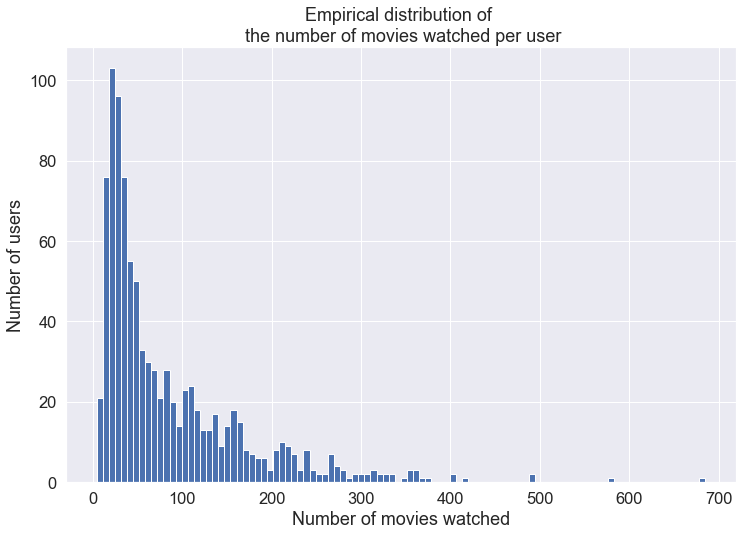

In [22]:
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.title('Empirical distribution of \n the number of movies watched per user')
plt.xlabel('Number of movies watched')
plt.ylabel('Number of users')
plt.hist(num_movies_watched, 100);

In [23]:
movie_popularity = np.mean(binarized_train_matrix, axis=0)  ## axis 0 refers to averaging across users
pd.DataFrame(movie_popularity).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1682.0,0.050437,0.068664,0.0,0.005302,0.022269,0.066808,0.513256


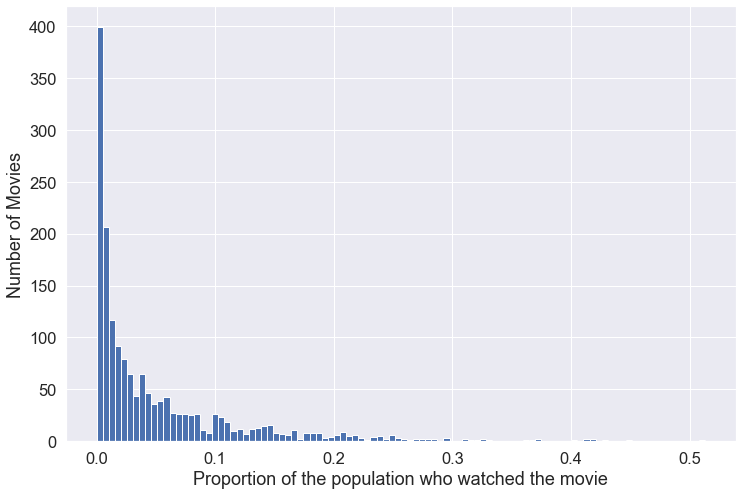

In [24]:
plt.xlabel('Proportion of the population who watched the movie')
plt.ylabel('Number of Movies')
plt.hist(movie_popularity, 100);

### Construindo o conjunto de treino e validação

In [44]:
def split(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

train = split(train_set, 0.8)
test = test_set

### Construindo o ciclo de aprendizado para o modelo

In [47]:
def learn_to_recommend(data, features=10, lr=0.0002, epochs=101, weigth_decay=0.02, stopping=0.001):
    """
    Args:
       data: every evaluation
       features: number of latent variables
       lr: learning rate for gradient descent
       epochs: number of iterations or maximum loops to perform
       weigth_decay: L2 regularization to predict rattings different of 0
       stopping: scalar associated with the stopping criterion
      
     Returns:
       P: latent matrix of users
       Q: latent matrix of items
       loss_train: vector of the different values of the loss function after each iteration on the train
       loss_valid: vector of the different values of the loss function after each iteration not on valid
       """
     
    train, valid = data[0], data[1]
    nb_users, nb_items = len(train), len(train[0])

    loss_train, loss_valid = [], []

    P = np.random.rand(nb_users, features) * 0.1
    Q = np.random.rand(nb_items, features) * 0.1
    
    for e in range(epochs):        
        for u in range(nb_users):
            for i in range(nb_items):

                if train[u][i] > 0:
                    error_ui = train[u][i] - prediction(P, Q, u, i)
                    P, Q = sgd(error_ui, P, Q, u, i, features, lr, weigth_decay)
                               
        loss_train.append(loss(train, P, Q))
        loss_valid.append(loss(valid, P, Q))
        
        if e % 10 == 0:
            print('Epoch : ', "{:3.0f}".format(e+1), ' | Train :', "{:3.3f}".format(loss_train[-1]), 
                  ' | Valid :', "{:3.3f}".format(loss_valid[-1]))

        if e > 1:
            if abs(loss_valid[-1] - loss_valid[-2]) < stopping:
                break
        
    return P, Q, loss_train, loss_valid

### Loss Function para otimização

In [48]:
def prediction(P, Q, u, i):
    """
    Args:
        P: user matrix
        Q: matrix of items
        u: index associated with user u
        i: index associated with item i
    Returns:
        pred: the predicted evaluation of the user u for the item i
    """
    
    return np.dot(P[u,:], Q[i,:])

def loss(data, P, Q):
    """
    Args:
       data: ratings
       P: matrix of users
       Q: matrix of items   
    Returns:
        MSE: observed mean of squared errors 
    """
    errors_sum, nb_evaluations = 0., 0
    nb_users, nb_items = len(data), len(data[0])

    for u in range(nb_users):
        for i in range(nb_items):
        
            if data[u][i] > 0:
                errors_sum += pow(data[u][i] - prediction(P, Q, u, i), 2)
                nb_evaluations += 1
                
    return errors_sum / nb_evaluations

### Estimativas

In [49]:
def sgd(error, P, Q, id_user, id_item, features, lr, weigth_decay):
    """
    Args:
        error: difference between observed and predicted evaluation (in that order)
        P: matrix of users
        Q: matrix of items
        id_user: id_user
        id_item: id_item
        features: number of latent variables
        lr: learning for the descent of the gradient
        weigth_decay: scalar multiplier controlling the influence of the regularization term
       
     Returns:
        P: the new estimate for P
        Q: the new estimate for Q
     """    
    for f in range(features):
        P[id_user, f] = P[id_user, f] + lr * (2 * Q[id_item, f] * error - 2 * weigth_decay * P[id_user, f])
        Q[id_item, f] = Q[id_item, f] + lr * (2 * P[id_user, f] * error - 2 * weigth_decay * Q[id_item, f])
      
    return P, Q

In [53]:
features = 5
lr = 0.01
epochs = 101
weigth_decay = 0.02
stopping = 0.001

P, Q, loss_train, loss_valid = learn_to_recommend(train, features, lr, epochs, weigth_decay, stopping)

Epoch :    1  | Train : 7.004  | Valid : 6.928
Epoch :   11  | Train : 0.790  | Valid : 0.964


Assim que o modelo é treinado, podemos visualizar as diferentes curvas de aprendizado

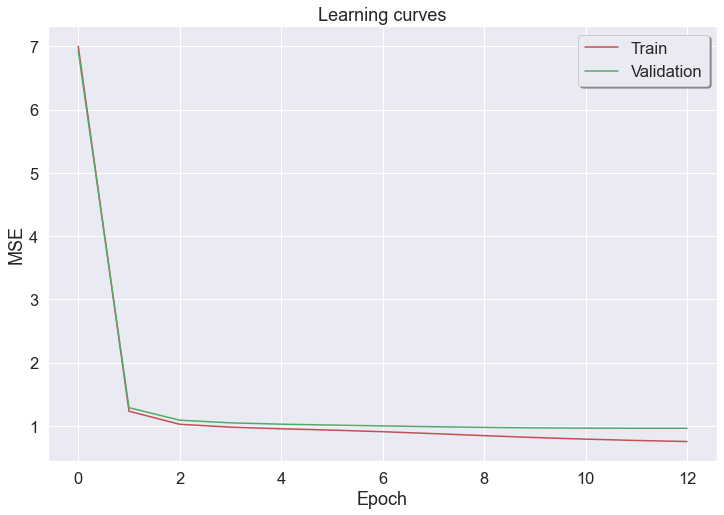

In [54]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)

## Análises

In [56]:
def explore(movie_titles, latent_matrix, frequency_mask, factor_idx, k):
    """
    Args:
       movie_titles: Pandas Series containing movie titles
        latent_matrix: matrix containing the model parameters for movies
        frequency_mask: boolean array masking non-frequent movies
        factor_idx: index of the latent variable
        k: number of movies to show

    Returns:
        names: movie titles
        scores: associated predicted ratings of movies
    """

    latent_variable = latent_matrix[:, factor] * frequency_mask

    nonzero_indices = np.nonzero(latent_variable)
    movies = np.array(movie_titles)[nonzero_indices][:k]
    latent_variable = latent_variable[nonzero_indices][:k]

    return movies, latent_variable

In [62]:
k = 10 # Número de filmes escolhidos
factor = 0
threshold = 0.1
names, scores = explore(df_movies['movie_title'], Q, np.where(movie_popularity > threshold, 1, 0), factor, k) # Escolher filmes apenas assistido por mais de 10% da população dos usuários

df = pd.DataFrame(np.matrix((names, scores)).T, (np.arange(len(scores)) + 1).tolist())
df.columns = ['Title', 'Latent factor']
df

,Title,Latent factor
1,Toy Story (1995),1.845801
2,GoldenEye (1995),0.97118
3,Get Shorty (1995),1.146015
4,Twelve Monkeys (1995),1.302513
5,Babe (1995),1.659521
6,Dead Man Walking (1995),1.000161
7,Seven (Se7en) (1995),1.686862
8,"Usual Suspects, The (1995)",1.881111
9,Mighty Aphrodite (1995),1.348871
10,"Postino, Il (1994)",1.554584


### Fazendo recomendações

In [65]:
def rank_top_k(names, ratings, k=10):
    
   """
   Example:
   a, b = np.array(['a', 'b', 'c']), np.array([6, 1, 3])
   a, b = rank_top_k(a, b, k=2)
   >>> a
   np.array('a', 'c')
   >>> b
   np.array([6, 3])
   """
 
   # rank indices in descending order
   ranked_ids = np.argsort(ratings)[::-1]
 
   return names[ranked_ids][:k], ratings[ranked_ids][:k]

In [70]:
user_id = 2 # Escolher um usuário
top_k = 10

# Definir a preferência do usuário usando nosso conjunto de treino
user_train = np.array(train[0][user_id])


# Definir que filmes o usuário ainda não assistiu, vamos apenas gerar recomendações para esses filmes
movies_not_seen = np.where(user_train == 0, 1, 0)

# Prever a avaliação do usuário para todos os filmes.
estimates = np.dot(P[user_id, :], Q.T)

# Considerar as avaliações estimadas para filmes que não foram vistos pelo usuário.
unseen_movie_estimates = estimates * movies_not_seen

# Retornar o top k recomendações para o usuário
recommendations, scores = rank_top_k(np.array(df_movies['movie_title']), unseen_movie_estimates, k=top_k)

# Mostrar o título e o predição de avaliação do usuário
df = pd.DataFrame(np.matrix((recommendations, scores)).T, (np.arange(10) + 1).tolist(), 
                  columns=['Título do filme', 'Avaliação prevista'])
df

,Título do filme,Avaliação prevista
1,Blade Runner (1982),4.578096
2,"Silence of the Lambs, The (1991)",4.514011
3,"Godfather, The (1972)",4.492528
4,"Close Shave, A (1995)",4.449049
5,"Shawshank Redemption, The (1994)",4.436774
6,One Flew Over the Cuckoo's Nest (1975),4.422437
7,Star Wars (1977),4.422232
8,"Usual Suspects, The (1995)",4.398054
9,"Wrong Trousers, The (1993)",4.392183
10,Schindler's List (1993),4.374314


---
### Exportando modelo

In [74]:
import pickle
filename = 'modelo.pk1'
pickle.dump(train[0], open(filename, 'wb'))

In [75]:
import joblib
joblib.dump(train[0], 'model.sav')

['model.sav']

---

### Informação da sessão

In [71]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.4.3
numpy               1.20.3
pandas              1.3.4
requests            2.26.0
seaborn             0.11.2
session_info        1.0.0
-----
IPython             7.29.0
jupyter_client      6.1.12
jupyter_core        4.8.1
jupyterlab          3.2.1
notebook            6.4.5
-----
Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22000-SP0
-----
Session information updated at 2022-04-27 17:53


---

Dataset citation

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872